### Prediccion de episodios criticos de la calidad del aire en Coyhaique

### 1.1 Carga de datos

In [5]:
import pandas as pd
from functools import reduce

# Función para cargar archivos horarios
def cargar_y_limpiar(filepath, nombre_variable):
    df = pd.read_csv(filepath, sep=';', skipinitialspace=True, dtype=str, na_values=['', 'NaN', 'nan'])
    df.columns = [col.strip().strip(';') for col in df.columns]

    df.rename(columns={df.columns[0]: 'FECHA', df.columns[1]: 'HORA', df.columns[2]: nombre_variable}, inplace=True)

    df['HORA'] = df['HORA'].str.zfill(4)
    df['datetime'] = pd.to_datetime('20' + df['FECHA'] + df['HORA'], format='%Y%m%d%H%M', errors='coerce')

    df[nombre_variable] = df[nombre_variable].str.replace(',', '.', regex=False)
    df[nombre_variable] = pd.to_numeric(df[nombre_variable], errors='coerce')

    return df[['datetime', nombre_variable]].sort_values('datetime').reset_index(drop=True)

# Función especial para el archivo diario de precipitación
def cargar_precipitacion_diaria(filepath, nombre_variable):
    df = pd.read_csv(filepath, sep=',', skipinitialspace=True, dtype=str, na_values=['', 'NaN', 'nan'])
    df.columns = [col.strip().strip('"') for col in df.columns]

    df.rename(columns={df.columns[0]: 'FECHA', df.columns[1]: nombre_variable}, inplace=True)
    df['datetime'] = pd.to_datetime(df['FECHA'], format='%d-%m-%Y', errors='coerce')

    df[nombre_variable] = df[nombre_variable].str.replace(',', '.', regex=False)
    df[nombre_variable] = pd.to_numeric(df[nombre_variable], errors='coerce')

    return df[['datetime', nombre_variable]].sort_values('datetime').reset_index(drop=True)

# Archivos horarios
archivos_vars = [
    ('Datos/Coyhaique/CO.csv',       'CO'),
    ('Datos/Coyhaique/HumRel.csv',   'HumRel'),
    ('Datos/Coyhaique/MP10.csv',     'MP10'),
    ('Datos/Coyhaique/MP25.csv',     'MP25'),
    ('Datos/Coyhaique/Presion.csv',  'Presion'),
    ('Datos/Coyhaique/Temp.csv',     'Temp'),
    ('Datos/Coyhaique/VelViento.csv','VelViento'),
]

# Cargar todos los archivos horarios
dfs = []
for archivo, var in archivos_vars:
    df_temp = cargar_y_limpiar(archivo, var)
    dfs.append(df_temp)

# Unir todos los archivos horarios por datetime
df_temuco = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='outer'), dfs)

# Rellenar CO, MP10, MP25 con valor de las 00:00 para cada día
df_temuco['date'] = df_temuco['datetime'].dt.date
df_temuco['hour'] = df_temuco['datetime'].dt.hour

for var in ['CO', 'MP10', 'MP25']:
    valores_0am = df_temuco[df_temuco['hour'] == 0][['date', var]].set_index('date')
    df_temuco[var] = df_temuco.apply(
        lambda row: valores_0am.loc[row['date'], var] if pd.isna(row[var]) and row['date'] in valores_0am.index else row[var],
        axis=1
    )

df_precip_dia = cargar_precipitacion_diaria('Datos/Coyhaique/Precip.csv', 'PrecipDia')
df_precip_dia['date'] = df_precip_dia['datetime'].dt.date
df_temuco = pd.merge(df_temuco, df_precip_dia[['date', 'PrecipDia']], on='date', how='left')
df_temuco.drop(columns=['date', 'hour'], inplace=True)
print(df_temuco.head(24))


     datetime        CO  HumRel      MP10      MP25  Presion  Temp  VelViento  \
0  2013-09-01  0.762502     NaN  107.4580  105.2920      NaN   NaN        NaN   
1  2013-09-02  0.829169     NaN  108.6250   98.6666      NaN   NaN        NaN   
2  2013-09-03  0.329168     NaN   88.0833   80.5416      NaN   NaN        NaN   
3  2013-09-04  0.625002     NaN  114.2080  112.6250      NaN   NaN        NaN   
4  2013-09-05  0.504169     NaN  108.7920  103.9580      NaN   NaN        NaN   
5  2013-09-06  0.704168     NaN  121.5420  119.3330      NaN   NaN        NaN   
6  2013-09-07  0.391668     NaN   77.9583   73.3333      NaN   NaN        NaN   
7  2013-09-08  0.208334     NaN   72.8750   71.5416      NaN   NaN        NaN   
8  2013-09-09  1.137500     NaN  130.8330  125.9580      NaN   NaN        NaN   
9  2013-09-10  0.808335     NaN   80.5416   77.0000      NaN   NaN        NaN   
10 2013-09-11  0.925003     NaN  118.0420  102.9580      NaN   NaN        NaN   
11 2013-09-12  1.262500     

In [6]:
df_temuco['VelViento'] = df_temuco['VelViento'].fillna(0)
df_temuco['CO'] = df_temuco['CO'].fillna(0)
df_temuco.isnull().sum()

datetime         0
CO               0
HumRel        9619
MP10          7848
MP25          7128
Presion      17154
Temp          9686
VelViento        0
PrecipDia    43182
dtype: int64

In [7]:
df_temuco.shape

(102366, 9)

DESCRIPCION DE LOS DATOS

In [8]:
df_temuco['datetime'] = pd.to_datetime(df_temuco['datetime'])

data_2324 = df_temuco[(df_temuco['datetime'] >= '2023-01-01') &(df_temuco['datetime'] <= '2024-12-31')]
data_n = df_temuco[df_temuco['datetime'] <= '2022-12-31']

data = data_n.dropna()
data.isnull().sum()
data.shape

(39697, 9)

### 1.2 Normalizacion

In [9]:
from sklearn.preprocessing import StandardScaler

data_numerica = data.select_dtypes(include='number')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_numerica)

df_scaled = pd.DataFrame(X_scaled, columns=data_numerica.columns)

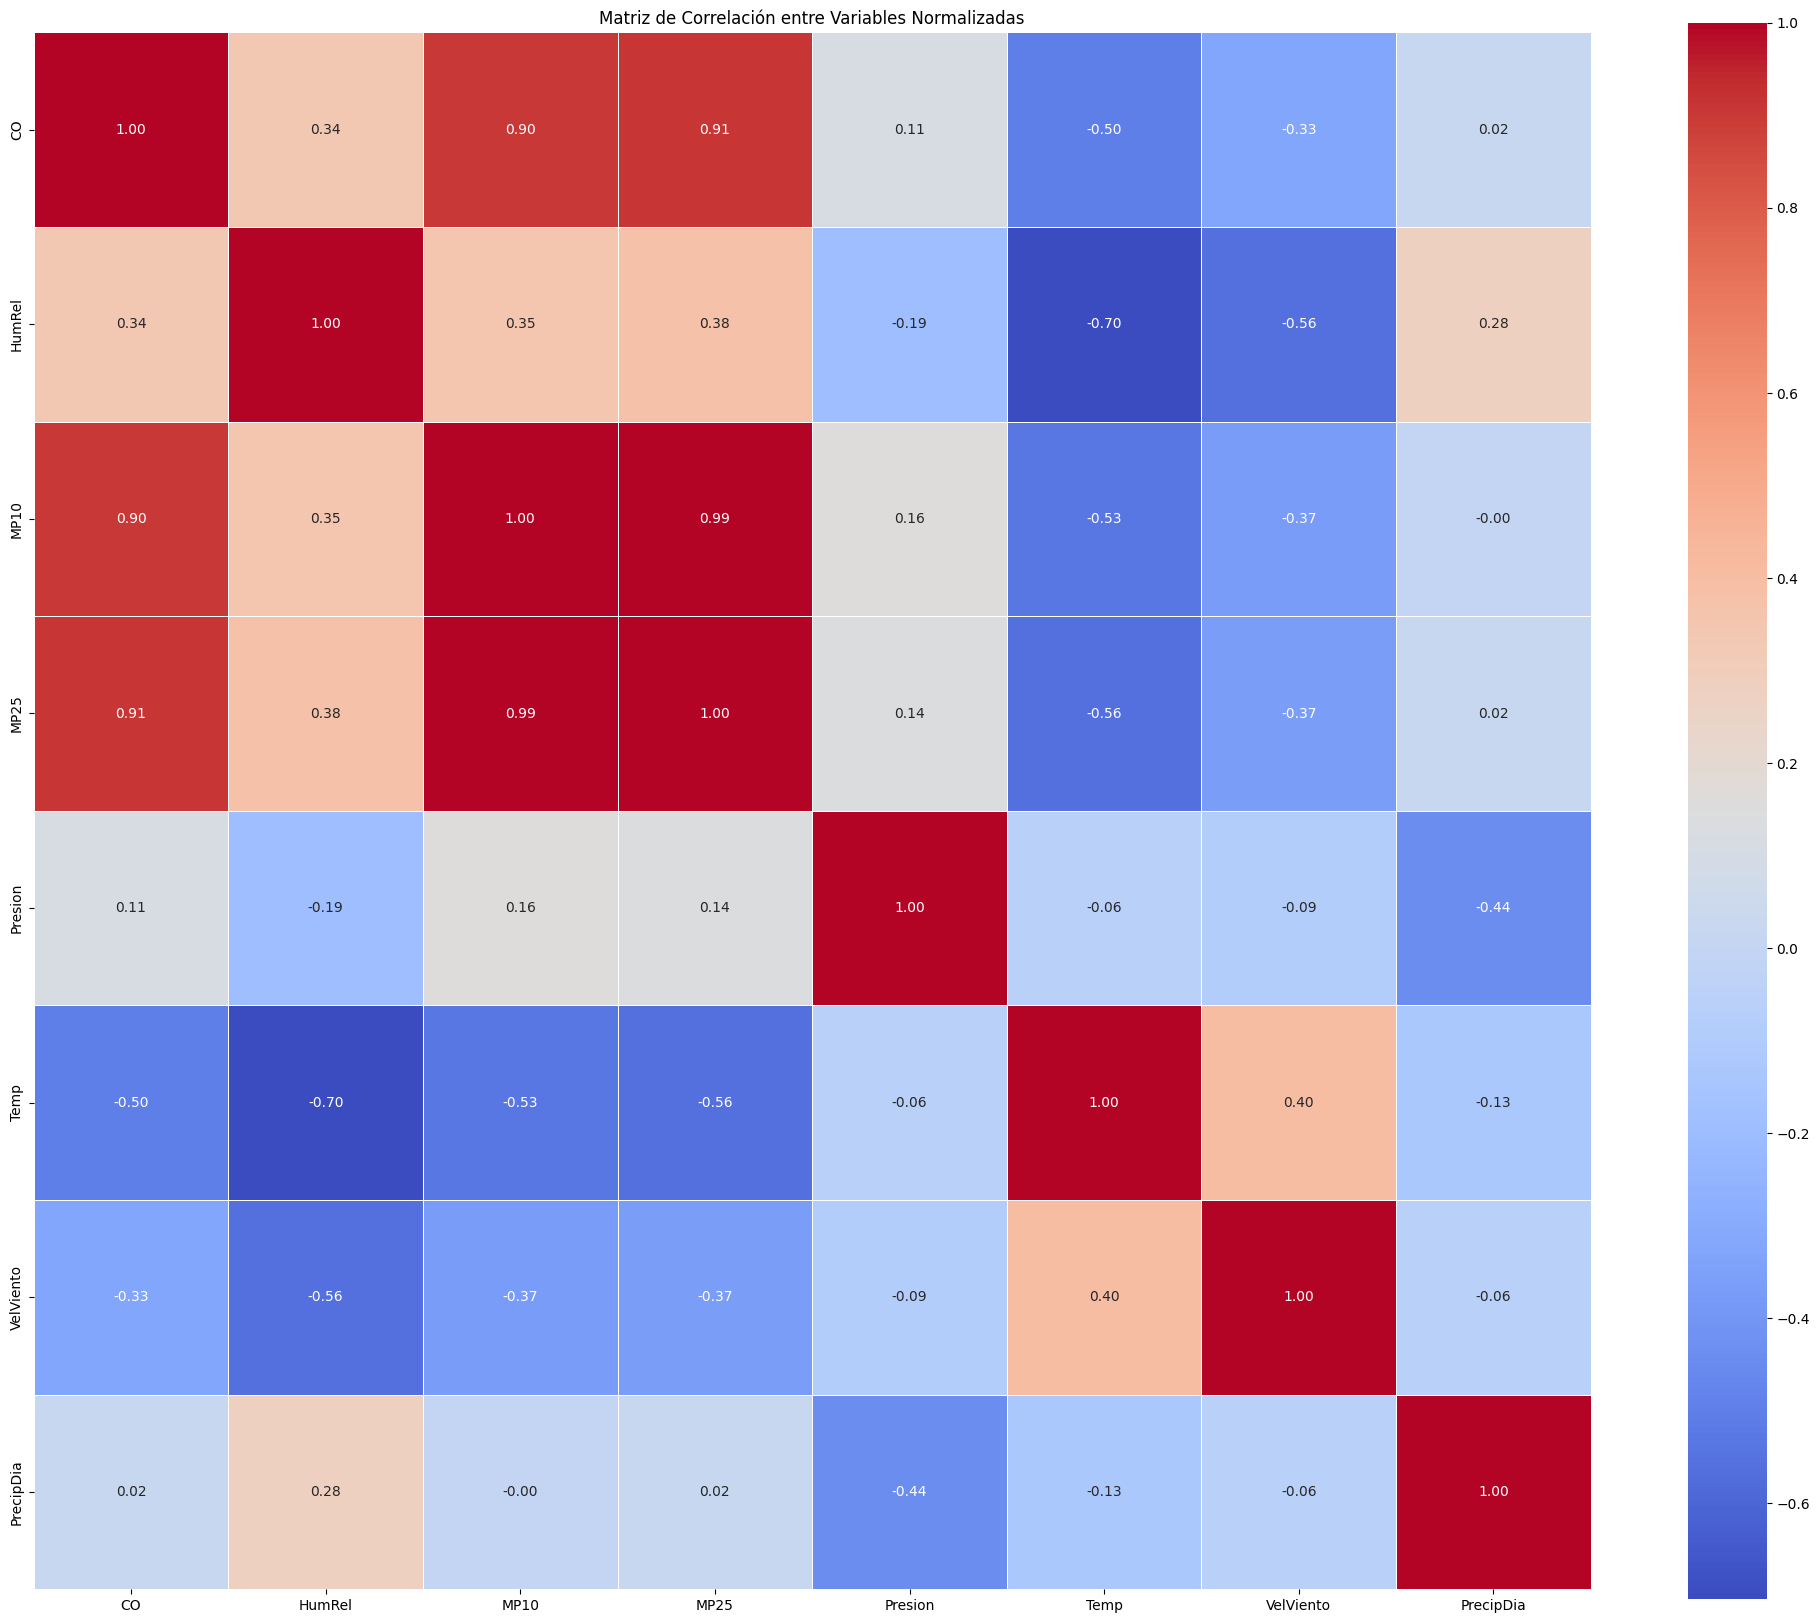

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df_scaled.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Matriz de Correlación entre Variables Normalizadas")
plt.tight_layout()
plt.show()

Aplicamos PCA

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


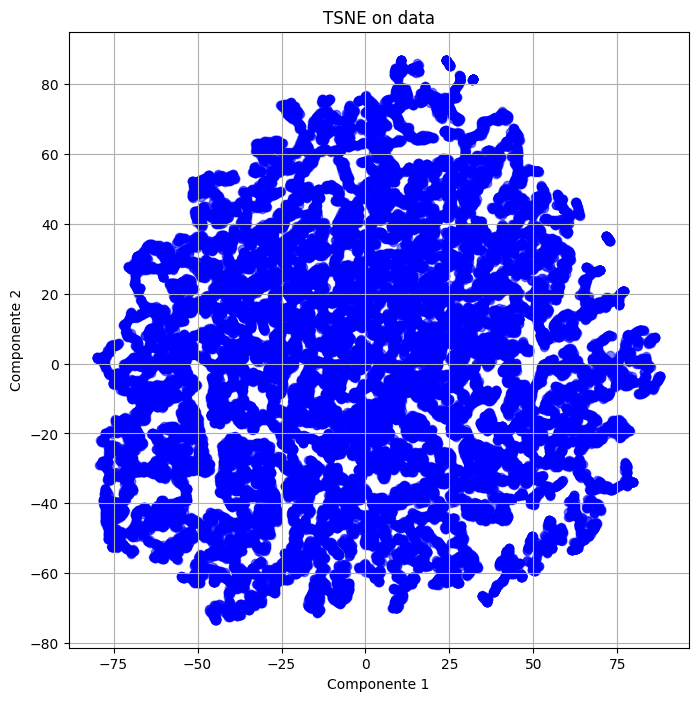

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity = 30, learning_rate=200, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

def plot_embedding(X, title):
    plt.figure(figsize=(8,8))
    plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', alpha=0.5)
    plt.title(title)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.grid(True)
    plt.show()

plot_embedding(X_tsne, 'TSNE on data')

c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


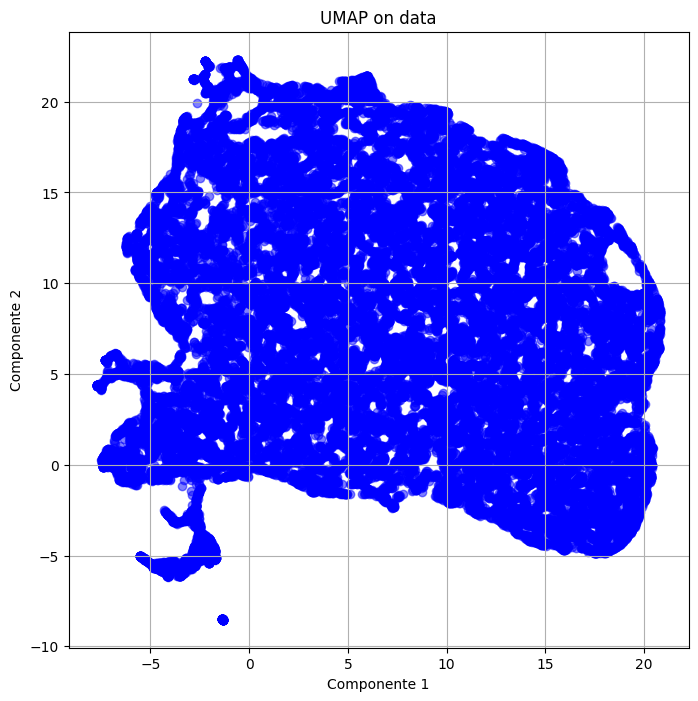

In [13]:
import umap

reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_pca)

plot_embedding(X_umap, 'UMAP on data')

DBSCAN

In [14]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)  

clusters_db = dbscan.fit_predict(X_pca)

df_scaled['cluster_dbscan'] = clusters_db


In [15]:
import hdbscan

hdb = hdbscan.HDBSCAN(min_cluster_size=15)

clusters_hdb = hdb.fit_predict(X_pca)

df_scaled['cluster_hdbscan'] = clusters_hdb

c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\ianma\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


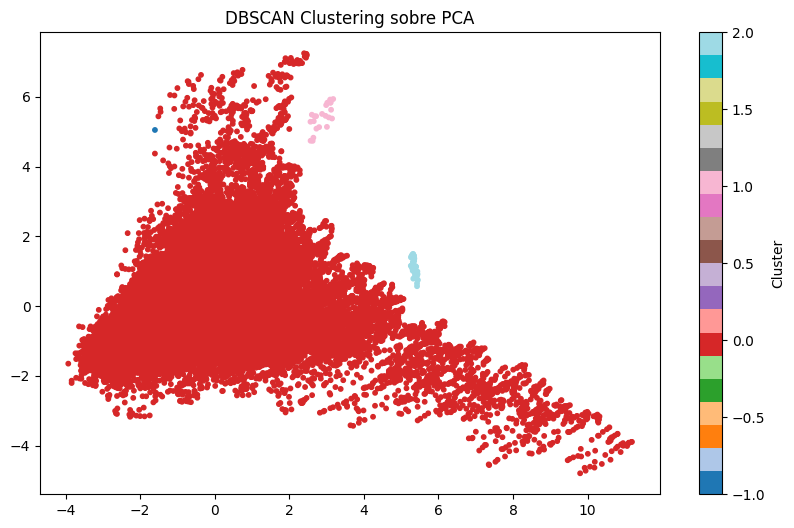

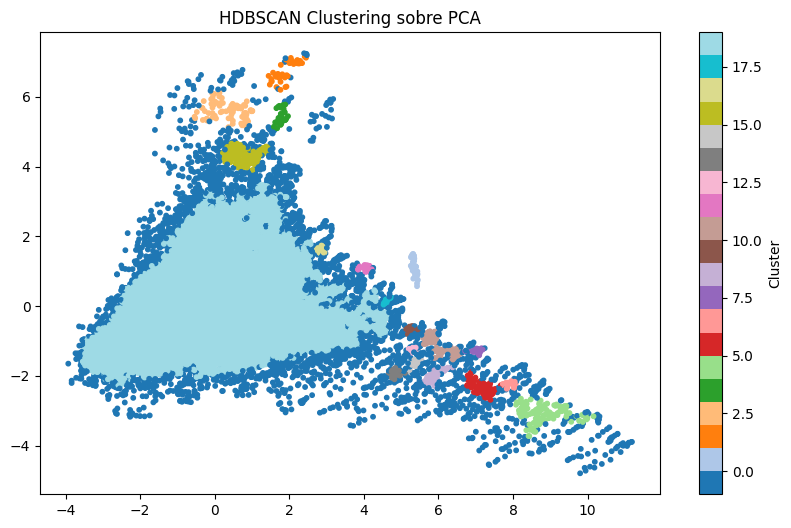

In [16]:
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_scaled['cluster_dbscan'], cmap='tab20', s=10)
plt.title('DBSCAN Clustering sobre PCA')
plt.colorbar(label='Cluster')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_scaled['cluster_hdbscan'], cmap='tab20', s=10)
plt.title('HDBSCAN Clustering sobre PCA')
plt.colorbar(label='Cluster')
plt.show()

KNN (en proceso para entrega 2)

In [17]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 1. Selecciondo las caract y excluyendo MP10, MP25 y CO
features = ['HumRel', 'PrecipDia', 'Presion', 'Temp', 'VelViento']
X = data[features]
y = data[['MP10', 'MP25', 'CO']] # Son las variables objetivo

# Escalado
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3. División en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=1
)

# Probando KNN multisalida
knn_reg = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5))
knn_reg.fit(X_train, y_train)
y_pred_knn = knn_reg.predict(X_test)

# Probando Modelo RandomForest multisalida
rf_reg = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=1))
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)

# Evaluando...
for name, y_pred in [('KNN', y_pred_knn), ('RF', y_pred_rf)]:
    print(f"\n=== Resultados con {name} ===")
    for i, col in enumerate(y.columns):
        r2  = r2_score(y_test.iloc[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
        mse = mean_squared_error(y_test.iloc[:, i], y_pred[:, i])
        print(f"{col:>4} → R2: {r2:.3f}, MAE: {mae:.3f}, MSE: {mse:.3f}")



=== Resultados con KNN ===
MP10 → R2: 0.545, MAE: 21.259, MSE: 1464.377
MP25 → R2: 0.569, MAE: 19.306, MSE: 1287.139
  CO → R2: 0.474, MAE: 0.366, MSE: 0.343

=== Resultados con RF ===
MP10 → R2: 0.594, MAE: 20.099, MSE: 1308.157
MP25 → R2: 0.617, MAE: 18.203, MSE: 1143.732
  CO → R2: 0.546, MAE: 0.334, MSE: 0.296


Probando inicialmente GMM:

In [18]:
from linearmodels.iv import IVGMM
import statsmodels.api as sm
import pandas as pd
import numpy as np

# Crear rezagos
df_temuco_lagged = df_temuco.copy()
df_temuco_lagged['CO_lag1'] = df_temuco_lagged['CO'].shift(1)

# Subset de datos
data_gmm = df_temuco_lagged[['MP10', 'CO', 'Temp', 'VelViento', 'Presion', 'HumRel', 'CO_lag1']].dropna()

# Variable dependiente
y = data_gmm['MP10']

# Variables exógenas (sin constante por ahora)
X_exog = data_gmm[['Temp', 'VelViento', 'Presion', 'HumRel']]

# Variables endógenas
X_endog = data_gmm[['CO']]

# Solo el rezago como instrumento para CO
Z = data_gmm[['CO_lag1']]

# Verificar correlación del instrumento
print(f"Correlación CO con CO_lag1: {data_gmm['CO'].corr(data_gmm['CO_lag1']):.3f}")

# GMM
try:
    gmm_model = IVGMM(y, X_exog, X_endog, Z)
    res = gmm_model.fit()
    print(res.summary)
except Exception as e:
    print(f"Error: {e}")
    print("Intentando con constante añadida...")
    
    # Agregar constante a exógenas
    X_exog_const = sm.add_constant(X_exog)
    gmm_model = IVGMM(y, X_exog_const, X_endog, Z)
    res = gmm_model.fit()
    print(res.summary)



Correlación CO con CO_lag1: 0.992
                          IV-GMM Estimation Summary                           
Dep. Variable:                   MP10   R-squared:                      0.9110
Estimator:                     IV-GMM   Adj. R-squared:                 0.9110
No. Observations:               79670   F-statistic:                 5.415e+05
Date:                Mon, Jun 23 2025   P-value (F-stat)                0.0000
Time:                        22:38:16   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Temp          -1.7382     0.0312    -55.694     0.0000     -1.7994     -1.6771
VelViento     -2.5


##################  HORIZONTE +24 h  ##################

⏳ Ajustando IV-GMM para CO (+24 h)
                          IV-GMM Estimation Summary                           
Dep. Variable:              CO_lead24   R-squared:                      0.4671
Estimator:                     IV-GMM   Adj. R-squared:                 0.4671
No. Observations:               41529   F-statistic:                 1.336e+04
Date:                Mon, Jun 23 2025   P-value (F-stat)                0.0000
Time:                        22:38:17   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
OOS  R²=0.411  RMSE=0.48  MAE=0.34

⏳ Ajustando IV-GMM para MP10 (+24 h)
                          IV-GMM Estimation Summary                           
Dep. Variable:            MP10_lead24   R-squared:                      0.4347
Estimator:                     IV-GMM   Adj.

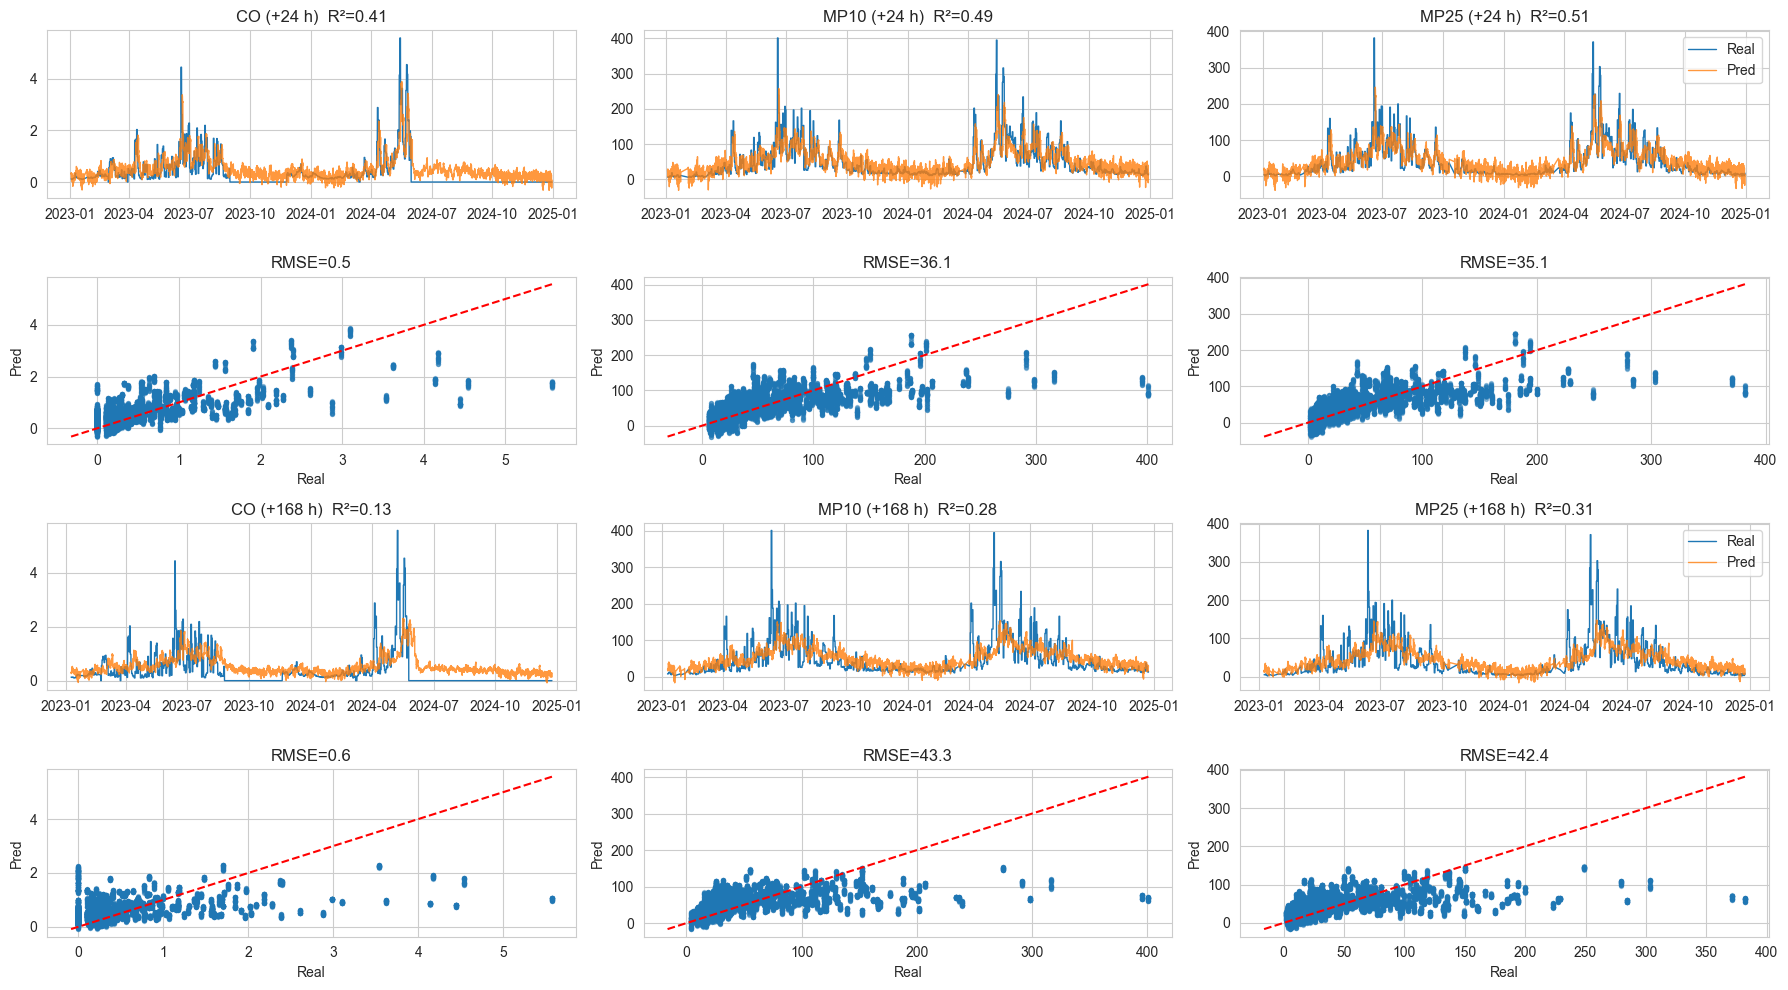

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.iv import IVGMM
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

df_temuco = df_temuco.drop(columns=["HumRel"], errors="ignore")
df_temuco = df_temuco.sort_values("datetime").reset_index(drop=True)

TRAIN_END  = "2022-12-31"
TEST_START = "2023-01-01"
TEST_END   = "2024-12-31"

train = df_temuco[df_temuco["datetime"] <= TRAIN_END].copy()
test  = df_temuco[(df_temuco["datetime"] >= TEST_START) &
                  (df_temuco["datetime"] <= TEST_END)].copy()

TARGETS      = ["CO", "MP10", "MP25"]
WEATHER_VARS = ["PrecipDia", "Presion", "Temp", "VelViento"]
HORIZONS_H   = [24, 168]                     # +1 día, +1 semana

def add_lags_and_leads(df: pd.DataFrame, tgt: str, h: int):
    """Añade lags (1,2,24,48,h,h+24) y lead-h para tgt."""
    for lag in [1, 2, 24, 48, h, h + 24]:
        df[f"{tgt}_lag{lag}"] = df[tgt].shift(lag)
    df[f"{tgt}_lead{h}"] = df[tgt].shift(-h)
    return df

def fit_ivgmm_direct(tgt: str, h: int, df_train: pd.DataFrame):
    """
    IV-GMM directo:
      y         = tgt_lead{h}
      endógeno  = tgt_lag{h}
      instrumento = tgt_lag{h+24}
      exógenos  = clima + lag24 + lag48 (solo si no chocan con endógeno/instrumento)
    """
    base_lags   = [24, 48]
    exog_lags   = [l for l in base_lags if l not in [h, h + 24]]

    cols = ([f"{tgt}_lead{h}",
             f"{tgt}_lag{h}",
             f"{tgt}_lag{h + 24}"] +
            [f"{tgt}_lag{l}" for l in exog_lags] +
            WEATHER_VARS)

    df   = df_train[cols].dropna()

    y      = df[f"{tgt}_lead{h}"]
    X_exog = sm.add_constant(
                df[WEATHER_VARS + [f"{tgt}_lag{l}" for l in exog_lags]],
                has_constant="add")
    X_end  = df[[f"{tgt}_lag{h}"]]
    Z      = df[[f"{tgt}_lag{h + 24}"]]

    model  = IVGMM(y, X_exog, X_end, Z)
    res    = model.fit(iter_limit=2)
    return res

def evaluate(res, tgt: str, h: int, df_test: pd.DataFrame):
    """Predicciones y métricas OOS."""
    base_lags = [24, 48]
    exog_lags = [l for l in base_lags if l not in [h, h + 24]]

    cols = ([f"{tgt}_lead{h}",
             f"{tgt}_lag{h}",
             f"{tgt}_lag{h + 24}"] +
            [f"{tgt}_lag{l}" for l in exog_lags] +
            WEATHER_VARS)

    df = df_test[cols].dropna()

    y_true = df[f"{tgt}_lead{h}"]
    X_exog = sm.add_constant(
                df[WEATHER_VARS + [f"{tgt}_lag{l}" for l in exog_lags]],
                has_constant="add")
    X_end  = df[[f"{tgt}_lag{h}"]]

    y_pred = res.predict(exog=X_exog, endog=X_end)

    r2   = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    return y_true, y_pred, {"r2": r2, "rmse": rmse, "mae": mae}

for tgt in TARGETS:
    for h in HORIZONS_H:
        for df in (train, test):
            add_lags_and_leads(df, tgt, h)

results, resumen = {}, []

for h in HORIZONS_H:
    print(f"\n##################  HORIZONTE +{h} h  ##################")
    for tgt in TARGETS:
        print(f"\n⏳ Ajustando IV-GMM para {tgt} (+{h} h)")
        res = fit_ivgmm_direct(tgt, h, train)

        print(res.summary.tables[0])  # resumen corto
        y_true, y_pred, met = evaluate(res, tgt, h, test)
        print(f"OOS  R²={met['r2']:.3f}  RMSE={met['rmse']:.2f}  MAE={met['mae']:.2f}")

        results[(tgt, h)] = (res, y_true, y_pred, met)
        resumen.append({"Horizonte_h": h, "Variable": tgt,
                        "N_obs": len(y_true),
                        "R2": f"{met['r2']:.3f}",
                        "RMSE": f"{met['rmse']:.2f}",
                        "MAE": f"{met['mae']:.2f}"})


print("\n" + "="*90 + "\nRESUMEN OUT-OF-SAMPLE\n" + "="*90)
print(pd.DataFrame(resumen).to_string(index=False))


sns.set_style("whitegrid")
rows = 2 * len(HORIZONS_H)
fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * len(HORIZONS_H)))

for col_h, h in enumerate(HORIZONS_H):
    for col_t, tgt in enumerate(TARGETS):
        row = 2 * col_h
        res, y_true, y_pred, met = results[(tgt, h)]
        dates = test.loc[y_true.index, "datetime"]

        if isinstance(y_pred, pd.DataFrame):
            y_pred = y_pred.iloc[:, 0]

        # Serie temporal
        ax_ts = axes[row, col_t]
        ax_ts.plot(dates, y_true, label="Real", linewidth=1)
        ax_ts.plot(dates, y_pred, label="Pred", linewidth=1, alpha=0.8)
        ax_ts.set_title(f"{tgt} (+{h} h)  R²={met['r2']:.2f}")
        if col_t == 2:
            ax_ts.legend()

        # Scatter
        ax_sc = axes[row + 1, col_t]
        ax_sc.scatter(y_true, y_pred, s=8, alpha=0.4)
        vmin = float(np.nanmin([y_true.min(), y_pred.min()]))
        vmax = float(np.nanmax([y_true.max(), y_pred.max()]))
        ax_sc.plot([vmin, vmax], [vmin, vmax], "r--")
        ax_sc.set_xlabel("Real"); ax_sc.set_ylabel("Pred")
        ax_sc.set_title(f"RMSE={met['rmse']:.1f}")

plt.tight_layout(); plt.show()


Mejorando el R2 de los modelos....

In [20]:
import pandas as pd, numpy as np
from linearmodels.iv import IVGMM
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
import warnings; warnings.filterwarnings("ignore")

df_temuco = df_temuco.drop(columns=["HumRel"], errors="ignore").sort_values("datetime")

TRAIN_END, TEST_START, TEST_END = "2022-12-31", "2023-01-01", "2024-12-31"
train = df_temuco[df_temuco.datetime <= TRAIN_END].copy()
test  = df_temuco[(df_temuco.datetime >= TEST_START) &
                  (df_temuco.datetime <= TEST_END)].copy()

TARGETS      = ["CO", "MP10", "MP25"]
WEATHER      = ["PrecipDia", "Presion", "Temp", "VelViento"]
HORIZONS_H   = [24, 168]                # +1 día  / +1 semana

def add_common_feats(df, tgt, h):
    """Crea lags/lead del target, lags clima y dummies hora-dow."""
    t_lags = [0, 1, 2, 24, 48, h, h+24, h+48]
    if h > 24:       t_lags.append(h-24)        # persistencia diaria
    if h == 168:     t_lags += [h-168, h+72]    # persist. semanal + lag +72 (instrumento)
    for lag in set(t_lags):
        df[f"{tgt}_lag{lag}"] = df[tgt].shift(lag)
    df[f"{tgt}_lead{h}"] = df[tgt].shift(-h)

    for var in WEATHER:
        df[f"{var}_lag24"] = df[var].shift(24)
        df[f"{var}_lag48"] = df[var].shift(48)

    df["hour"] = df.datetime.dt.hour
    df["dow"]  = df.datetime.dt.dayofweek
    df = pd.concat(
        [df,
         pd.get_dummies(df["hour"], prefix="hr",  drop_first=True),
         pd.get_dummies(df["dow"],  prefix="dow", drop_first=True)],
        axis=1
    )
    return df

def choose_instruments(tgt, h, df):
    """Devuelve Z con lags escogidos para evitar Hansen < 0.05."""
    Z_cols = [f"{tgt}_lag{h+24}"]                     # 1er instrumento
    if tgt == "CO":                                   # CO admite 2 instrumentos
        Z_cols.append(f"{tgt}_lag{h+48}")
    elif tgt in ("MP10", "MP25") and h == 168:        # MP10/25 semanal usa lag +72
        Z_cols.append(f"{tgt}_lag{h+72}")
    return df[Z_cols]

def build_exog(df, tgt, h):
    """Lista de columnas exógenas (sin duplicados)."""
    exog = WEATHER + [f"{v}_lag24" for v in WEATHER] + [f"{v}_lag48" for v in WEATHER]
    exog.append(f"{tgt}_lag{h-24}" if h > 24 else f"{tgt}_lag0")
    if h == 168:
        exog.append(f"{tgt}_lag{h-168}")              # valor exacto hace una semana
    exog += [c for c in df.columns if c.startswith(("hr_","dow_"))]
    return list(dict.fromkeys(exog))

def fit_iv_gmm(tgt, h, df_train):
    df  = add_common_feats(df_train.copy(), tgt, h).dropna()
    y   = df[f"{tgt}_lead{h}"]
    X_e = sm.add_constant(df[build_exog(df, tgt, h)], has_constant="add")
    X_n = df[[f"{tgt}_lag{h}"]]
    Z   = choose_instruments(tgt, h, df)

    res = IVGMM(
            y, X_e, X_n, Z,
            weight_type="kernel", kernel="bartlett", bandwidth=48
          ).fit(iter_limit=2)
    return res, X_e.columns.tolist()

def predict(res, ex_cols, tgt, h, df_test):
    df = add_common_feats(df_test.copy(), tgt, h).dropna()
    y  = df[f"{tgt}_lead{h}"]
    cols = [c for c in ex_cols if c != "const"]
    X_e  = sm.add_constant(df[cols], has_constant="add")
    X_n  = df[[f"{tgt}_lag{h}"]]
    return y, res.predict(exog=X_e, endog=X_n)

summary = []
for h in HORIZONS_H:
    print(f"\n########  HORIZONTE +{h} h  ########")
    for tgt in TARGETS:
        res, excols   = fit_iv_gmm(tgt, h, train)
        y_true, y_hat = predict(res, excols, tgt, h, test)

        r2   = r2_score(y_true, y_hat)
        rmse = np.sqrt(mean_squared_error(y_true, y_hat))
        hans = res.j_stat.pval

        print(f"{tgt}:  R²={r2:.3f}  RMSE={rmse:.2f}  Hansen p={hans:.3f}")
        summary.append({"Horiz(h)":h,"Var":tgt,
                        "R2":round(r2,3),"RMSE":round(rmse,2),"Hansen_p":round(hans,3)})

print("\n", pd.DataFrame(summary)
         .pivot(index="Var", columns="Horiz(h)", values=["R2","RMSE","Hansen_p"]))





########  HORIZONTE +24 h  ########
CO:  R²=0.639  RMSE=0.38  Hansen p=1.000
MP10:  R²=0.622  RMSE=31.29  Hansen p=nan
MP25:  R²=0.633  RMSE=30.42  Hansen p=nan

########  HORIZONTE +168 h  ########
CO:  R²=0.067  RMSE=0.62  Hansen p=0.006
MP10:  R²=0.253  RMSE=44.69  Hansen p=0.163
MP25:  R²=0.271  RMSE=43.97  Hansen p=0.048

              R2          RMSE        Hansen_p       
Horiz(h)    24     168    24     168      24     168
Var                                                 
CO        0.639  0.067   0.38   0.62      1.0  0.006
MP10      0.622  0.253  31.29  44.69      NaN  0.163
MP25      0.633  0.271  30.42  43.97      NaN  0.048


Graficando...

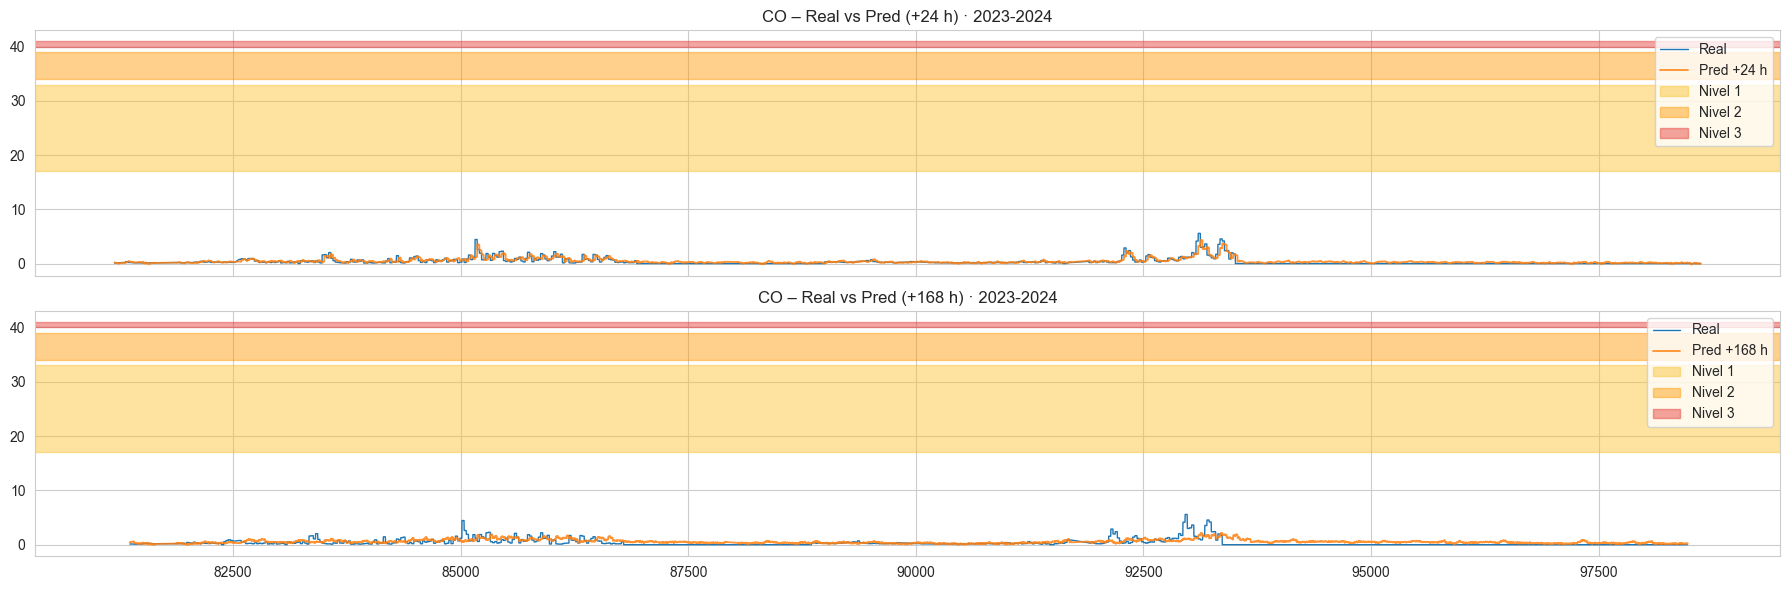

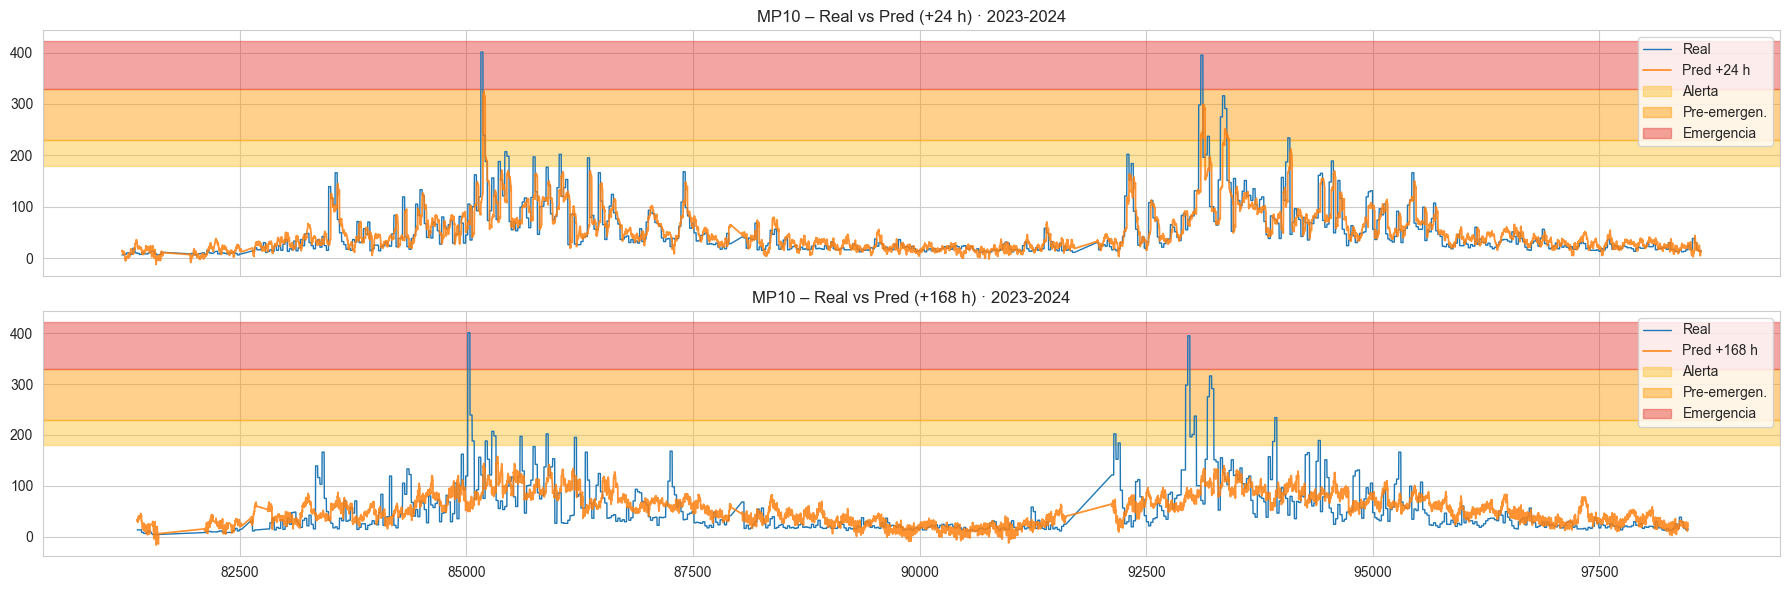

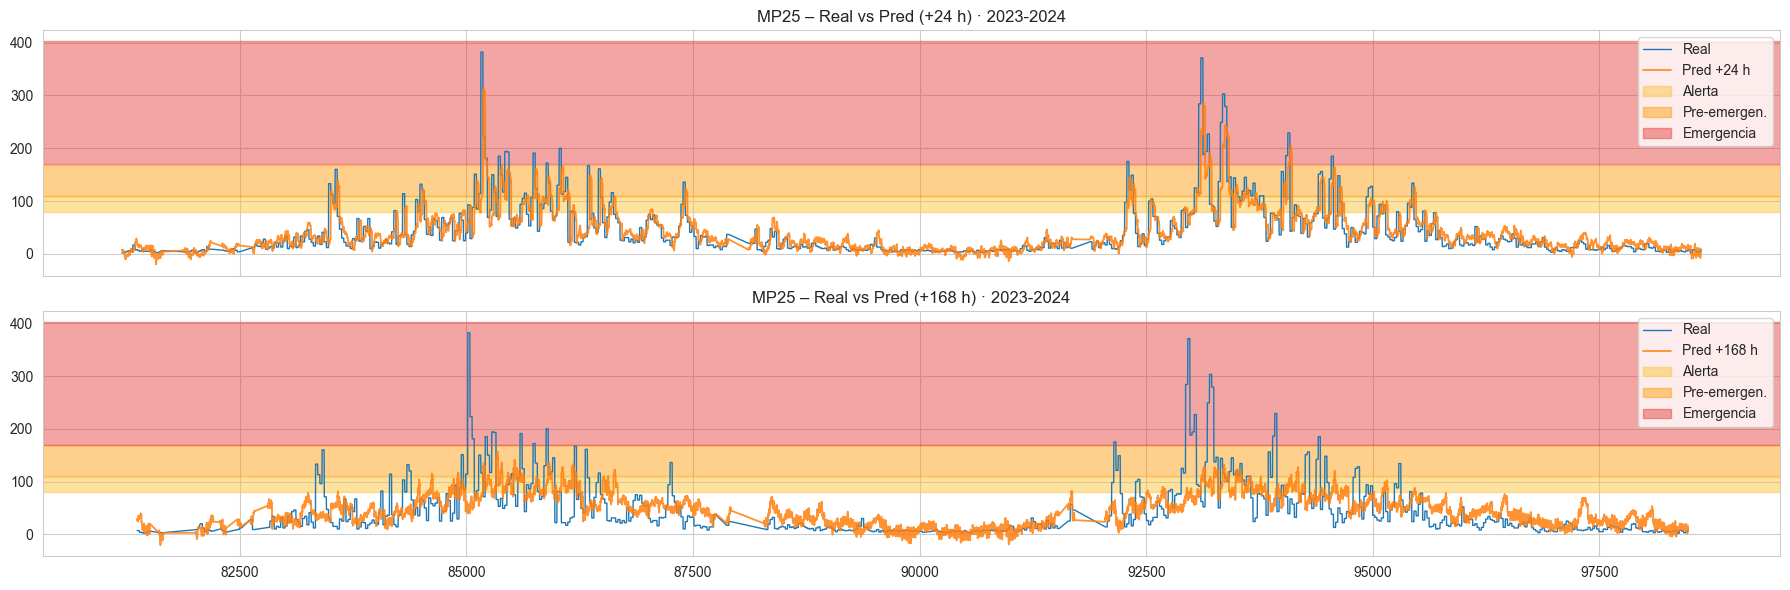

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

pred_store = {}
for h in HORIZONS_H:
    for tgt in TARGETS:
        res, excols = fit_iv_gmm(tgt, h, train)
        y, yhat     = predict(res, excols, tgt, h, test)
        pred_store[(tgt, h)] = (y.index, y, yhat)

bands = {
    "CO":   [("Nivel 1", 17, 33,  "#FBC02D"),  
             ("Nivel 2", 34, 39,  "#FF9800"),   
             ("Nivel 3", 40, None,"#E53935")],  
    "MP25": [("Alerta",        80,109, "#FBC02D"),
             ("Pre-emergen.", 110,169, "#FF9800"),
             ("Emergencia",   170,None,"#E53935")],
    "MP10": [("Alerta",        180,229,"#FBC02D"),
             ("Pre-emergen.", 230,329,"#FF9800"),
             ("Emergencia",   330,None,"#E53935")]
}

def add_bands(ax, tgt):
    for label, low, high, color in bands[tgt]:
        top = high if high is not None else ax.get_ylim()[1]
        ax.axhspan(low, top, color=color, alpha=0.45, label=label)

for tgt in TARGETS:
    fig, axes = plt.subplots(2, 1, figsize=(18, 6), sharex=True)
    
    # +24 h
    d, y, yhat = pred_store[(tgt, 24)]
    axes[0].plot(d, y,     label="Real", linewidth=1)
    axes[0].plot(d, yhat,  label="Pred +24 h", linewidth=1.3, alpha=0.85)
    add_bands(axes[0], tgt)
    axes[0].set_title(f"{tgt} – Real vs Pred (+24 h) · 2023-2024")
    axes[0].legend(loc="upper right")
    
    # +168 h
    d, y, yhat = pred_store[(tgt, 168)]
    axes[1].plot(d, y,     label="Real", linewidth=1)
    axes[1].plot(d, yhat,  label="Pred +168 h", linewidth=1.3, alpha=0.85)
    add_bands(axes[1], tgt)
    axes[1].set_title(f"{tgt} – Real vs Pred (+168 h) · 2023-2024")
    axes[1].legend(loc="upper right")
    
    plt.tight_layout()
    plt.show()




In [22]:
import pandas as pd

dates, y_real, y_pred = pred_store[("MP25", 24)]      

if isinstance(y_pred, pd.DataFrame):
    y_pred = y_pred.iloc[:, 0]

def clase_mp25(x):
    if x >= 170:  return "Emergencia"
    if x >= 110:  return "Preemergencia"
    if x >=  80:  return "Alerta"
    return "Sin episodio"

niveles = ["Sin episodio","Alerta","Preemergencia","Emergencia"]

y_true_cls = y_real.map(clase_mp25).astype("category").cat.set_categories(niveles)
y_pred_cls = y_pred.map(clase_mp25).astype("category").cat.set_categories(niveles)

tabla = (pd.crosstab(y_true_cls, y_pred_cls)
           .reindex(index=niveles, columns=niveles, fill_value=0))

tabla["Total_real"] = tabla.sum(axis=1)

tot_pred = tabla.sum(axis=0)
tot_pred.name = "Total_predicho"

tabla = pd.concat([tabla, tot_pred.to_frame().T], axis=0)

print("\nTABLA DE EPISODIOS MP25 – +24 h (2023-2024)\n")
print(tabla.to_string())





TABLA DE EPISODIOS MP25 – +24 h (2023-2024)

predictions     Sin episodio  Alerta  Preemergencia  Emergencia  Total_real
Sin episodio           12990     520            268          24       13802
Alerta                   479     355            114          24         972
Preemergencia            265     488            364          24        1141
Emergencia                24     128            200         152         504
Total_predicho         13758    1491            946         224       16419
